# Estimating Home Values

Project goals:
- Perform EDA on Zillow dataset to see which features predict house prices well.
- Construct a ML Regression model that predicts property values.

## Imports

In [1]:
import wrangle as w
import explore as e
import model as m

import sys
import os
home_directory_path = os.path.expanduser('~')
sys.path.append(home_directory_path +'/utils')
from prepare_utils import split_data

%config InlineBackend.figure_format = 'retina'

from scipy import stats

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression

In [2]:
# import warnings
# warnings.filterwarnings("ignore")

## Wrangle

- Acquiring zillow data form MySQL
- Clean data
    - keep only 2017 transactions
    - handle duplicate rows, id's, and homes in duplications
    - rename columns
    - handle missing values
    - filter out outliers from my data
        - 1-4 bathrooms
        - 1-6 bedrooms
        - age < 105
        - sqft < 5,000 and > 500
        - property_value < 1,500,000 and > 50_000
    - convert data to appropriate data types (floats, integers, etc.)

In [3]:
data = w.prep_zillow()
data.head()

,parcelid,id,bathrooms,bedrooms,sqft,fips,latitude,longitude,regionidcity,regionidzip,property_value,transaction_date,age,county
52520,12826780,1187175,2.0,3,1762,6037,33937685,-117996709,14634,96171,522000,2017-09-25,61,LA
52518,17239384,2968375,2.0,4,1612,6111,34300140,-118706327,27110,97116,67205,2017-09-21,52,Ventura
52517,11000655,673515,2.0,2,1286,6037,34245368,-118282383,12447,96284,354621,2017-09-20,76,LA
52508,12410050,2900077,1.0,2,1023,6037,33880374,-118112653,44116,96208,222739,2017-09-19,60,LA
52497,10867042,986237,2.0,3,2141,6037,34150146,-118490857,12447,96426,887003,2017-09-19,62,LA


**Note on data**:
- Homes from 3 California counties: LA, Orange, and Ventura

---
## Explore


Explore data in search of features that drive property value 

- Which features appear to relate to property value the most?
- Do home values vary significantly among the 3 counties?
- Do home values vary significantly among homes with x bedrooms and x bathrooms?

Key Insights:
- Strong Drivers of property value:
    - square footage
    - bathrooms
    - bedrooms
- Weak Drivers of property value:
    - county

Load training data to avoid data leakage and bias

In [4]:
train, _, _= split_data(data, validate_size=.15, test_size=.15, 
                         stratify_col='county', random_state=123)

train.columns

Index(['parcelid', 'id', 'bathrooms', 'bedrooms', 'sqft', 'fips', 'latitude',
       'longitude', 'regionidcity', 'regionidzip', 'property_value',
       'transaction_date', 'age', 'county'],
      dtype='object')

In [5]:
train = train[['bathrooms', 'bedrooms', 'sqft', 'property_value', 'age','county']]

**Which features appear to relate to property value the most?**

- Vizualize

`takeaway`

/Users/martinreyes/codeup-data-science/project_regression_predict_property_value/explore.py:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  ax = sns.heatmap(df.corr()['property_value'].sort_values(ascending=False).to_frame().iloc[1:,:],


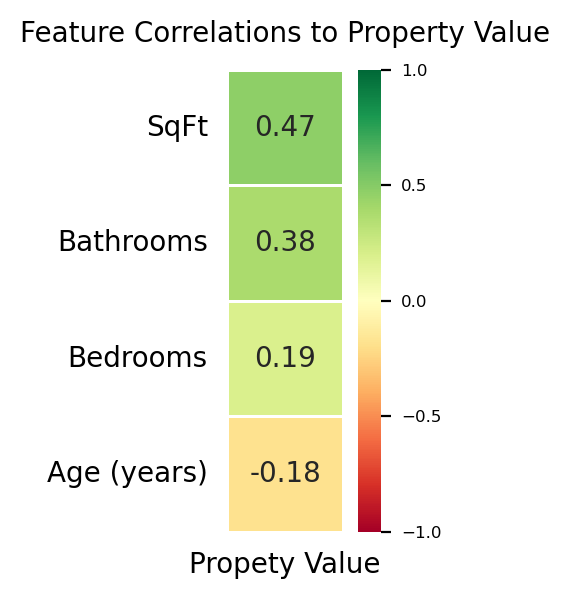

In [6]:
e.plot_target_heatmap(train)

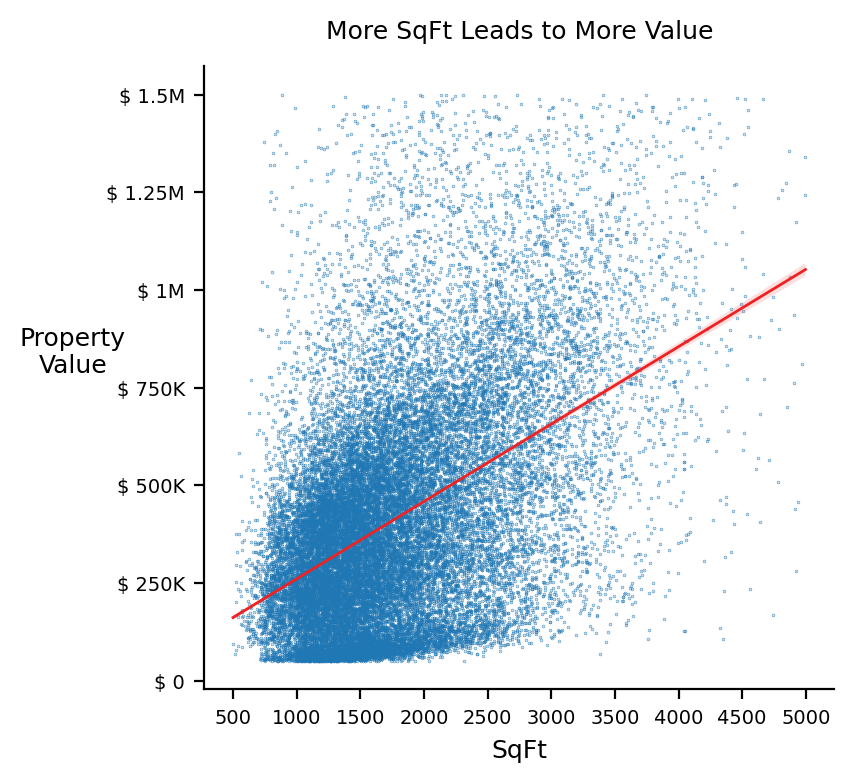

In [7]:
e.plot_sqft_to_value(train)

- Statistical test
    * Pearson correlation test
    * Hypotheses and significance level
        * $H_0$: There is no linear relationship between property value and square footage.
        * $H_a$: There is some linear relationship between property value and square footage.
        * $\alpha = .05$
- Verify Assumptions
    Normality: distributions are right skewed but we can bypass this with large sample sizes
    
Test:

In [8]:
pearson_r, p_val = stats.pearsonr(train['property_value'], train['sqft'])
print(f'Pearson R = {pearson_r}\nP value = {p_val}')

Pearson R = 0.4692160238974564
P value = 0.0


There's signicant evidence that there is a moderate positive correlation of around .47 between property value and square footage.

**Do home values vary significantly among the 3 counties?**



- Vizualize

`takeaway`

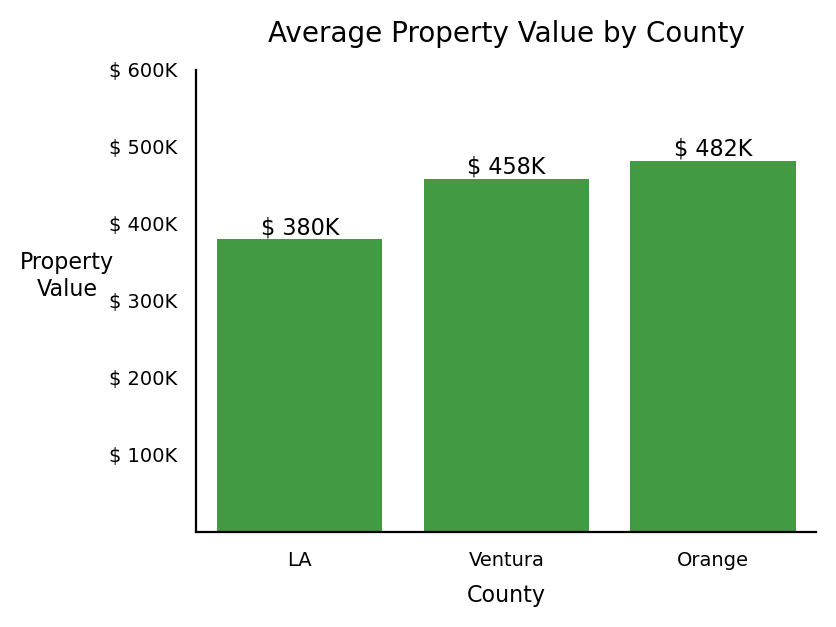

In [9]:
e.plot_value_average_by_county(train, 'property_value', 'county')

- Statistical test
    * ANOVA T-Test
    * Hypotheses and significance level
        * $H_0$: There is no difference in property value for homes in each county.
        * $H_a$: There is a difference in property value for homes in each county.
        * $\alpha = .05$
    * verify assumptions
        * Independence: Assumption met
        * Normality: Property values are right skewed, but assumption is met with large sample sizes
        * Equal Variances: Check with Levene's test
            * Variances are not equal, so we will set `equal_var=False` for the test

In [10]:
stat_levene, p_levene = stats.levene(train[train['county']=='LA']['property_value'],
                                     train[train['county']=='Orange']['property_value'],
                                     train[train['county']=='Ventura']['property_value'])
print(f'''A p value of {p_levene:.2e}, which is less than .05, indicates that our sample variances between
            churners and non-churners are not equal''')

A p value of 2.45e-24, which is less than .05, indicates that our sample variances between
            churners and non-churners are not equal


* Run ANOVA test
* Interpret the results of the test

In [11]:
stat, p_val = stats.f_oneway(train[train['county']=='LA']['property_value'],
                                     train[train['county']=='Orange']['property_value'],
                                     train[train['county']=='Ventura']['property_value'])
stat, p_val

(424.4714260770215, 1.2676805327165247e-182)

There's signicant evidence that there is some relationship between property value and bedrooms. However, the visuals show us this relationship isn't strong.

**Do home values vary significantly among those with X bathrooms?**

- Vizualize

`takeaway`

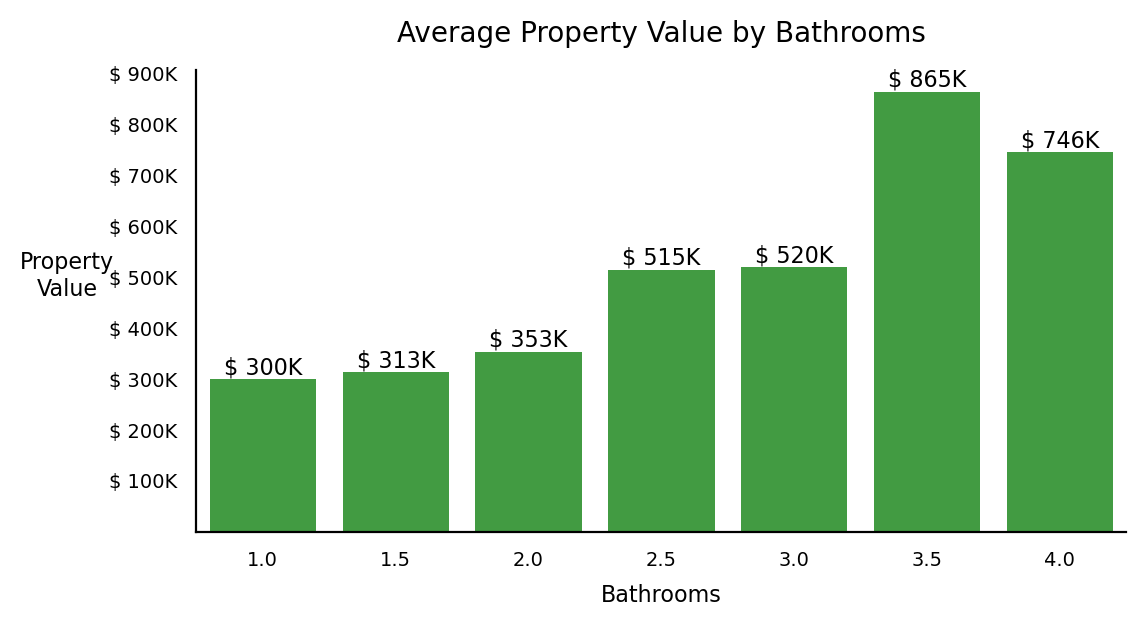

In [12]:
e.plot_value_average_by_bathrooms(train, 'property_value', 'bathrooms')

More bathrooms significantly leads to more value, but this relationahip doesn't seem to be consistent or linear.

**Do home values vary significantly among those with X bedrooms?**

- Vizualize

`takeaway`

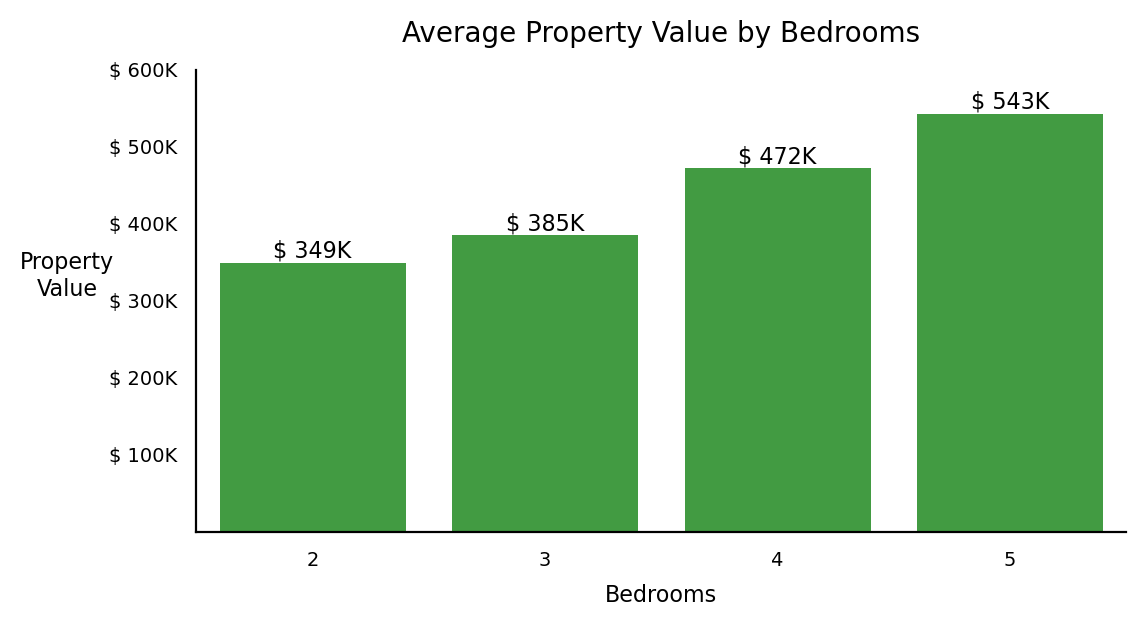

In [13]:
e.plot_value_average_by_bedrooms(train, 'property_value', 'bedrooms')

- Statistical test
    * Independent (Two-Sample) T-Test (2-sided)
    * Hypotheses and significance level
        * $H_0$: There is no difference in property value for homes in each county.
        * $H_a$: There is a difference in property value for homes in each county.
        * $\alpha = .05$
    * verify assumptions
        * Independence: Assumption met
        * Normality: Assumption met with large sample sizes
        * Equal Variances: Check with Levene's test
            * Variances are not equal, so we will set `equal_var=False` for the test

In [14]:
stat_levene, p_levene = stats.levene(train[train['bedrooms']==2]['property_value'],
                                     train[train['bedrooms']==3]['property_value'],
                                     train[train['bedrooms']==4]['property_value'],
                                     train[train['bedrooms']==5]['property_value'])
print(f'''A p value of {p_levene:.2e}, which is less than .05, indicates that our sample variances between
            churners and non-churners are not equal''')

A p value of 3.18e-103, which is less than .05, indicates that our sample variances between
            churners and non-churners are not equal


* Run test
* Interpret the results of the test

In [15]:
stat, p_val = stats.f_oneway(train[train['bedrooms']==2]['property_value'],
                             train[train['bedrooms']==3]['property_value'],
                             train[train['bedrooms']==4]['property_value'],
                             train[train['bedrooms']==5]['property_value'])
stat, p_val

(408.2200356208768, 3.653893557815671e-260)

More bedrooms leads to more value, and this relationahip seem to be consistent and linear. However, it is not are strong as bathrooms or square feet.

**Exploration Summary**

Key Insights:
- Strong Drivers of property value:
    - square footage
    - bathrooms
    - bedrooms
- Weak Drivers of property value:
    - county

Features to model on:
- sqft and bathrooms


---
## Modeling

Run Linear Regression Models and evaluate their RMSE and coefficient of determination ($R^2$)

- Before modeling, I will encode bathrooms and scale sqft (Min-Max scaling). Scale is based on training data to avoid data leakage.

- I will split the data into train, validate, and test. I will also split the data into features (X) and target (y).

In [16]:
X_train_scaled, X_validate_scaled, X_test_scaled,\
    y_train, y_vaildate, y_test, scaler = \
        m.preprocess_zillow_data(data)

In [17]:
X_train_scaled

array([[0.44740938, 0.        , 1.        , 0.        ],
       [0.38314432, 0.        , 1.        , 0.        ],
       [0.37091394, 0.        , 0.        , 1.        ],
       ...,
       [0.25817211, 1.        , 0.        , 0.        ],
       [0.50166778, 0.        , 1.        , 0.        ],
       [0.40004447, 1.        , 0.        , 0.        ]])

### Baseline 
* Dummy regression model (`sklearn.DummyRegressor`) which essentially predicts the mean property value for each input.

In [20]:
train_rmse, test_rmse, train_r2, test_r2 =\
    m.run_model(X_train_scaled, y_train, X_validate_scaled, y_vaildate,
                DummyRegressor(), scaler,
                features = ['sqft','1_2_bathrooms','2.5_3_bathrooms','3.5_4_bathrooms'])

In [21]:
train_rmse, test_rmse, train_r2, test_r2

(285789.35772279406, 284299.5855448087, 0.0, -0.00021994792340773728)

### Best Performing Model

- Pooled Linear Regression Model
- Features: sqft, bathrooms

In [22]:
train_rmse, test_rmse, train_r2, test_r2, coeffs, coeffs_unscaled =\
    m.run_model(X_train_scaled, y_train, X_validate_scaled, y_vaildate,
                LinearRegression(), scaler,
                features = ['sqft','1_2_bathrooms','2.5_3_bathrooms','3.5_4_bathrooms'])

,coefficients
sqft,158.064093
1_2_bathrooms,-70955.836297
2.5_3_bathrooms,-29610.355644
3.5_4_bathrooms,100566.191941
intercept,262733.975215


In [23]:
train_rmse, test_rmse, train_r2, test_r2

(250774.7683349454, 245332.5950403372, 0.2300268678548748, 0.25517616863736114)

In [27]:
train['property_value'].std()

285793.90934224275

### Modeling Wrap

* Best model:
    - Linear Regression Model trained on SqFt and bathrooms
* Model Performance
    - RMSE is &#36;250K
        - Model predictions were off on average &#36;250K
        - compared to &#36;285K for our baseline model
    - R^2 score: 0.26
        - 26% of variance explained
* Model insights
    - linear model:
        - starts at &#36;262K
        - adds &#36;158 for every sqft
        - subtracts &#36;71K if the home has 1 to 2 bathrooms
        - subtracts &#36;30K if the home has 2.5 or 3 bathrooms
        - adds &#36;100K if the home has 3.5 or 4 bathrooms


## Conclusion

### Summary
* summarize findings/drivers and answers
* state model performance compared to baseline

### Recommendations
* Recommend stakeholder actions
* Recommend models to use

### Next Steps
With more time, I can:
- Engineer features the categorize home location
    - using zipcodes or latitude and longitude
- Train a ML model on these features if they are strong drivers
- Run non-linear regression models
- Use non-linear feature scaling techniques to fit linear models better